**IMPORTING NECESSARY LIBRARIES/MODULES AND IMPORTANT THINGS**

In [1]:
# import relevant libraries/modules
import ssl
import os
import sys
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import Model
from keras import applications
from keras.applications import MobileNet
from keras.callbacks import ModelCheckpoint
import random

2023-04-06 12:14:20.874782: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# training dataset 
Datadirectory = "train" #<--- name of the folder where the training dataset is stored

In [3]:
# list of classes
Classes = ["0", "1", "2", "3", "4", "5", "6"] #<--- the different faces that it can detect in order ["Angry","Disgust","Fear","Happy","Neutral","Sad","Surprise"]

**READING IN ALL TRAINING IMAGES, MAKING THEM ALL THE SAME SIZE AND NORMALIZING THEM AND THEN STORING THEM ALL IN AN ARRAY**

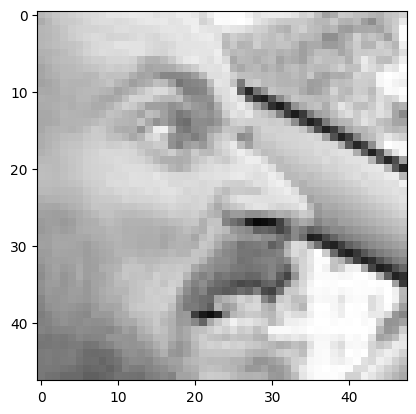

In [4]:
for category in Classes:
    path = os.path.join(Datadirectory, category)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img))
        plt.imshow(cv2.cvtColor(img_array,cv2.COLOR_BGR2RGB))
        plt.show()
        break
    break

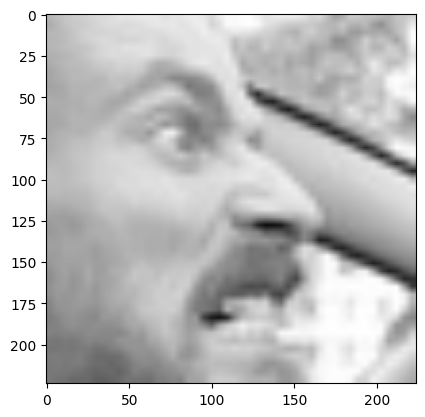

In [5]:
# change the image size to 224x224 so that its less pixelated
img_size = 224
new_image = cv2.resize(img_array,(img_size, img_size))
plt.imshow(cv2.cvtColor(new_image,cv2.COLOR_BGR2RGB))
plt.show()

In [6]:
# read all the images and convert them to array
training_data = [] # data array to store the images

def create_training_data():
    for category in Classes:
        path = os.path.join(Datadirectory,category)
        class_num = Classes.index(category) 
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path,img))
                new_image = cv2.resize(img_array,(img_size, img_size))
                training_data.append([new_image,class_num])
                
            except Exception as e:
                pass
            
    return training_data

In [7]:
# call the function that was created above
create_training_data()

[[array([[[183, 183, 183],
          [183, 183, 183],
          [183, 183, 183],
          ...,
          [211, 211, 211],
          [211, 211, 211],
          [211, 211, 211]],
  
         [[183, 183, 183],
          [183, 183, 183],
          [183, 183, 183],
          ...,
          [210, 210, 210],
          [211, 211, 211],
          [211, 211, 211]],
  
         [[182, 182, 182],
          [182, 182, 182],
          [183, 183, 183],
          ...,
          [211, 211, 211],
          [212, 212, 212],
          [212, 212, 212]],
  
         ...,
  
         [[120, 120, 120],
          [120, 120, 120],
          [120, 120, 120],
          ...,
          [171, 171, 171],
          [170, 170, 170],
          [170, 170, 170]],
  
         [[120, 120, 120],
          [120, 120, 120],
          [120, 120, 120],
          ...,
          [170, 170, 170],
          [170, 170, 170],
          [170, 170, 170]],
  
         [[120, 120, 120],
          [120, 120, 120],
          [120, 120, 120

In [8]:
print(len(training_data))

3336


In [9]:
# shuffling the data for accuracy
random.shuffle(training_data)

In [10]:
x = [] # data/features
y = [] # label

for features,label in training_data:
    x.append(features)
    y.append(label)

x = np.array(x).reshape(-1,img_size,img_size,3) # converting to 4D arrays (image, height, width, channels) <-- It can process color images 

In [11]:
print(len(x))

3336


In [12]:
# normalizing the data
x = x/255.0 # <-- ensures uniformity in how your data looks, reads, and can be utilized

In [13]:
y = np.array(y)

**USING A PRETRAINED MODEL WITH ITS OWN WEIGHTS AND THEN TUNING THE WEIGHTS TO BETTER SUIT OUR TRAINING DATA**

In [14]:
# deep learning model for training - transfer learning
model = tf.keras.applications.MobileNetV3Small() # pre-trained model
model.summary()

# this line of code solves the SSL error which occurs because I don't know
ssl._create_default_https_context = ssl._create_unverified_context

2023-04-06 12:15:39.304532: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "MobilenetV3small"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 Conv (Conv2D)                  (None, None, None,   432         ['rescaling[0][0]']              
                                16)                                                

In [15]:
# transfer learning - tuning, weights will start from the last checkpoint
base_input = model.layers[0].input # input

base_output = model.layers[-2].output

In [16]:
base_output

<KerasTensor: shape=(None, 1000) dtype=float32 (created by layer 'flatten')>

In [17]:
final_output = layers.Dense(128)(base_output) # adding a new layer after the output of the global pooling layer
final_output = layers.Activation('relu')(final_output) # activation function
final_output = layers.Dense(64)(base_output) 
final_output = layers.Activation('relu')(final_output)
final_output = layers.Dense(7, activation = 'softmax')(final_output) # classification layer with 7 classes (7 because there are 7 emotions)
# softmax is a classification layer 

In [18]:
final_output #output

<KerasTensor: shape=(None, 7) dtype=float32 (created by layer 'dense_2')>

**TRAINING THE ALGORITHM**

In [19]:
#new_model = keras.Model(inputs = base_input,outputs = final_output) # create a new model from the input and output layers
#new_model.summary()
#new_model.compile(loss="sparse_categorical_crossentropy",optimizer="adam",metrics=["accuracy"]) # compile the model

In [20]:
#new_model.fit(x,y,epochs=5) # train the model with the training data 5 times
#new_model.save('final_model01.h5') # save the model
#new_model.summary()

In [21]:
#new_model.fit(x,y,epochs=5) # train the model with the training data 5 times
#new_model.save('final_model02.h5') # save the model
#new_model.summary()

In [22]:
#new_model.fit(x,y,epochs=5) # train the model with the training data 5 times
#model.save('final_model03.h5') # save the model
#new_model.summary()

In [23]:
#new_model.fit(x,y,epochs=5) # train the model with the training data 5 times
#new_model.save('final_model04.h5') # save the model
#new_model.summary()

In [24]:
#new_model.fit(x,y,epochs=5) # train the model with the training data 5 times
#new_model.save('final_model05.h5') # save the model
#new_model.summary()

In [25]:
#new_model.fit(x,y,epochs=5) # train the model with the training data 5 times
#new_model.save('final_model06.h5') # save the model
#new_model.summary()

In [26]:
#new_model.fit(x,y,epochs=5) # train the model with the training data 5 times
#new_model.save('final_model07.h5') # save the model
#new_model.summary()

**LOADING THE BEST TRAINING REUSLTS FROM ABOVE AND USING THAT**

In [27]:
# load the best model 
new_model = tf.keras.models.load_model('final_model07.h5')

# check the model summary --> should match the one above which is the model after the training 
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 Conv (Conv2D)                  (None, None, None,   432         ['rescaling[0][0]']              
                                16)                                                           

**LAUNCHING THE CAMERA AND USING THE HAARCASCADE ALGORITHM TO DETECT THE FACE FROM THE VIDEO STREAM AND MAKE A PREDICTION**

In [28]:
# name of the haarcascade file 
path = 'haarcascade_frontalface_default.xml'

# set the font style and size
font_scale = 1.5
font = cv2.FONT_HERSHEY_SIMPLEX

# set the rectangle background to white
rectangle_bgr = (255, 255, 255)

# making a black image
img = np.zeros((500, 500, 3))

# label on the bottom of the window
text = "Emotion Detector Project - By: Ayman Karim"

# get the width and height of the text box
(text_width, text_height) = cv2.getTextSize(text, font, fontScale=font_scale, thickness=1)[0]

# set the text start position
text_offset_x = 10
text_offset_y = img.shape[0] - 25

# make the coords of the box with a small padding of two pixels
box_coords = ((text_offset_x, text_offset_y), (text_offset_x + text_width + 2, text_offset_y - text_height - 2))

cv2.rectangle(img, box_coords[0], box_coords[1], rectangle_bgr, cv2.FILLED)
cv2.putText(img, text, (text_offset_x, text_offset_y), font, fontScale=font_scale, color=(0, 0, 0), thickness=1)

# open webcam
cap = cv2.VideoCapture(0)

# Check if the webcam is opened correctly and raise an error if not
if not cap.isOpened():
    cap = cv2.VideoCapture(1)
if not cap.isOpened():
    raise IOError("Cannot open webcam")

win_name = "Emotion Detection Project"
cv2.namedWindow(win_name, cv2.WINDOW_NORMAL)

while True:
    ret, frame = cap.read()
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + path)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.1, 4)

    face_roi = np.zeros((img_size, img_size, 3))

    for x, y, w, h in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = frame[y:y+h, x:x+w]
        cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)
        inner_faces = face_cascade.detectMultiScale(roi_gray)

        if len(inner_faces) == 0:
            print("Face is not detected")            
        else:
            for ex, ey, ew, eh in inner_faces:
                face_roi = roi_color[ey:ey+eh, ex:ex+ew] # cropping the face

    final_image = cv2.resize(face_roi, (img_size, img_size))
    final_image = np.expand_dims(final_image, axis=0) # making the image 4D 
    final_image = final_image / 255.0 # normalizing the image

    prediction = new_model.predict(final_image) # predict the emotion

    # if the prediction is angry then the person is angry
    if np.argmax (prediction) == 0:
        status = "Angry"
        x1, y1, w1, h1 = 0,0,175,75
        # draw the black rectangle and write the emotion in it
        cv2.rectangle(frame,(x1,x1),(x1+w1,y1+h1),(0,0,0),-1)
        cv2.putText(frame,status,(x1+int(w1/10),y1+int(h1/2)),font, 0.7,(0,0,255),2)
        cv2.putText(frame,status,(100, 150),font,3,(0,0,255),2,cv2.LINE_4)
        cv2.rectangle(frame,(x1,y1),(x1+w1,y1+h1),(0,0,255))

    # if the prediction is disgust then the person is disgusted 
    elif np.argmax(prediction) == 1:
        status = "Disgust"
        x1, y1, w1, h1 = 0,0,175,75
        # draw the black rectangle and write the emotion in it
        cv2.rectangle(frame,(x1,x1),(x1+w1,y1+h1),(0,0,0),-1)
        cv2.putText(frame,status,(x1+int(w1/10),y1+int(h1/2)),font, 0.7,(0,0,255),2)
        cv2.putText(frame,status,(100, 150),font,3,(0,0,255),2,cv2.LINE_4)
        cv2.rectangle(frame,(x1,y1),(x1+w1,y1+h1),(0,0,255))

    # if the prediction is fear then the person is fearful
    elif np.argmax(prediction) == 2:
        status = "Fear"
        x1, y1, w1, h1 = 0,0,175,75
        # draw the black rectangle and write the emotion in it
        cv2.rectangle(frame,(x1,x1),(x1+w1,y1+h1),(0,0,0),-1)
        cv2.putText(frame,status,(x1+int(w1/10),y1+int(h1/2)),font, 0.7,(0,0,255),2)
        cv2.putText(frame,status,(100, 150),font,3,(0,0,255),2,cv2.LINE_4)
        cv2.rectangle(frame,(x1,y1),(x1+w1,y1+h1),(0,0,255))

    # if the prediction is happy then the person is happy
    elif np.argmax(prediction) == 3:
        status = "Happy"
        x1, y1, w1, h1 = 0,0,175,75
        # draw the black rectangle and write the emotion in it
        cv2.rectangle(frame,(x1,x1),(x1+w1,y1+h1),(0,0,0),-1)
        cv2.putText(frame,status,(x1+int(w1/10),y1+int(h1/2)),font, 0.7,(0,0,255),2)
        cv2.putText(frame,status,(100, 150),font,3,(0,0,255),2,cv2.LINE_4)
        cv2.rectangle(frame,(x1,y1),(x1+w1,y1+h1),(0,0,255))
                      
    # if the prediction is neuatral then the person is neutral 
    elif np.argmax(prediction) == 4:
        status = "Neutral"
        x1, y1, w1, h1 = 0,0,175,75
        # draw the black rectangle and write the emotion in it
        cv2.rectangle(frame,(x1,x1),(x1+w1,y1+h1),(0,0,0),-1)
        cv2.putText(frame,status,(x1+int(w1/10),y1+int(h1/2)),font, 0.7,(0,0,255),2)
        cv2.putText(frame,status,(100, 150),font,3,(0,0,255),2,cv2.LINE_4)
        cv2.rectangle(frame,(x1,y1),(x1+w1,y1+h1),(0,0,255))

    # if the prediction is sad then the person is sad
    elif np.argmax(prediction) == 5:
        status = "Sad"
        x1, y1, w1, h1 = 0,0,175,75
        # draw the black rectangle and write the emotion in it
        cv2.rectangle(frame,(x1,x1),(x1+w1,y1+h1),(0,0,0),-1)
        cv2.putText(frame,status,(x1+int(w1/10),y1+int(h1/2)),font, 0.7,(0,0,255),2)
        cv2.putText(frame,status,(100, 150),font,3,(0,0,255),2,cv2.LINE_4)
        cv2.rectangle(frame,(x1,y1),(x1+w1,y1+h1),(0,0,255))

    # if the prediction is surprise then the person is surprised 
    else:
        status = "Surprise"
        x1, y1, w1, h1 = 0,0,175,75
        # draw the black rectangle and write the emotion in it
        cv2.rectangle(frame,(x1,x1),(x1+w1,y1+h1),(0,0,0),-1)
        cv2.putText(frame,status,(x1+int(w1/10),y1+int(h1/2)),font, 0.7,(0,0,255),2)
        cv2.putText(frame,status,(100, 150),font,3,(0,0,255),2,cv2.LINE_4)
        cv2.rectangle(frame,(x1,y1),(x1+w1,y1+h1),(0,0,255))

    cv2.imshow('Emotion Detection Project',frame)
    cv2.waitKey(1)

    if cv2.waitKey(1) & 0xFF == ord('q'): #press q to stop the video streaming 
        break

cap.release()
cv2.destroyAllWindows()

Face is not detected
1/1 [==============================] - 3s 3s/step
Face is not detected
1/1 [==============================] - 0s 53ms/step
Face is not detected
1/1 [==============================] - 0s 46ms/step
Face is not detected
1/1 [==============================] - 0s 60ms/step
Face is not detected
1/1 [==============================] - 0s 52ms/step
Face is not detected
1/1 [==============================] - 0s 53ms/step
Face is not detected
1/1 [==============================] - 0s 47ms/step
Face is not detected
1/1 [==============================] - 0s 72ms/step
Face is not detected
1/1 [==============================] - 0s 44ms/step
Face is not detected
1/1 [==============================] - 0s 58ms/step
Face is not detected
Face is not detected
Face is not detected
1/1 [==============================] - 0s 46ms/step
Face is not detected
1/1 [==============================] - 0s 54ms/step
Face is not detected
1/1 [==============================] - 0s 57ms/step
Face is not